### 基于花类数据来进行tfdatasetrecord实战

In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print(tf.__version__)
print(tf.test.is_gpu_available()) 

2.0.0
True


## 将图片数据保存成为tfrecord格式

In [2]:
flower_dir="./flower_photos/flower_photos/"

daisy_dir=flower_dir+'daisy/'
dandelion_dir=flower_dir+'dandelion/'
roses_dir=flower_dir+'roses/'
sunflowers_dir=flower_dir+'sunflowers/'
tulips_dir=flower_dir+'tulips/'

In [3]:
len(os.listdir(daisy_dir))

12

In [4]:
#将图片路径读入，然后统一应用函数来解析
train_daisy=tf.constant([daisy_dir + filename for filename in os.listdir(daisy_dir)])
train_dandelion=tf.constant([dandelion_dir + filename for filename in os.listdir(dandelion_dir)])
train_roses=tf.constant([roses_dir + filename for filename in os.listdir(roses_dir)])
train_sunflowers=tf.constant([sunflowers_dir + filename for filename in os.listdir(sunflowers_dir)])
train_tulips=tf.constant([tulips_dir + filename for filename in os.listdir(tulips_dir)])

train_filenames=tf.concat([train_daisy,train_dandelion,train_roses,train_sunflowers,train_tulips],axis=-1)

In [5]:
# train_filenames

In [6]:
#处理标签
train_labels = tf.concat([
    tf.zeros(train_daisy.shape, dtype=tf.int32), 
    tf.ones(train_dandelion.shape, dtype=tf.int32),
    2*tf.ones(train_roses.shape, dtype=tf.int32),
    3*tf.ones(train_sunflowers.shape, dtype=tf.int32),
    4*tf.ones(train_tulips.shape, dtype=tf.int32)
    ], 
    axis=-1)

In [7]:
train_labels

<tf.Tensor: id=29, shape=(60,), dtype=int32, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])>

In [8]:
train_tfrecord_file ='./flower_train.tfrecords'#不需要事先存在

with tf.io.TFRecordWriter(train_tfrecord_file) as writer:
    for filename, label in zip(train_filenames, train_labels):
        image = open(filename.numpy(), 'rb').read()     # 读取数据集图片到内存，image 为一个 Byte 类型的字符串   
#         print(image)
        feature = {                             # 建立 tf.train.Feature 字典
            'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image])),  # 图片是一个 Bytes 对象
            'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))   # 标签是一个 Int 对象
        }
        example = tf.train.Example(features=tf.train.Features(feature=feature)) # 通过字典建立 Example
        writer.write(example.SerializeToString())   # 将Example序列化并写入 TFRecord 文件

## 评价
在创建tfrecord的时候容易存在数据读取有误。也就是在步骤image=open(filename,'rb').read()这一步，报错IOPub data rate exceeded

要尝试扩大容量
找到配置文件 jupyter_notebook_config.py中的iopub_data_rate_limit的数值要扩大N倍
1. 在prompt里面输入 jupyter notebook --generate-config
2. 在找到的jupyter_notebook_config.py中寻找iopub_data_rate_limit
3. 将iopub_data_rate_limit的数值扩大N倍,去掉前面的#
4. 重启anaconda

In [9]:
# help(tf.io.TFRecordWriter)

### 之后数据处理可以仿照别的程序
- 之后仿照4.1读入训练数据
- repeat
- shuffle
- batch
同样处理测试数据
- 构建模型
- 损失函数、优化器、评估函数
- 关键步骤变成静态函数
- 多epoch多batch来运行模型结果

In [10]:
train_dataset = tf.data.TFRecordDataset("flower_train.tfrecords")    # 读取 TFRecord 文件,此时的文件为图片

tf.Tensor(
[[[0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0.99607843]
  ...
  [0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0.99607843]]

 [[0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0.99607843]
  ...
  [0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0.99607843]]

 [[0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0.99607843]
  ...
  [0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0.99607843]]

 ...

 [[0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0.99607843]
  ...
  [0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0.99607843]]

 [[0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0

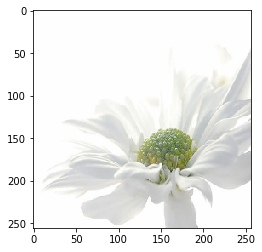

In [11]:
feature_description = { # 定义Feature结构，告诉解码器每个Feature的类型是什么
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64),
}

def _parse_example(example_string): # 将 TFRecord 文件中的每一个序列化的 tf.train.Example 解码
    feature_dict = tf.io.parse_single_example(example_string, feature_description)#读入的是图片
    feature_dict['image'] = tf.io.decode_jpeg(feature_dict['image'])    # 解码JPEG图片
    feature_dict['image'] = tf.image.resize(feature_dict['image'], [256, 256]) / 255.0
    return feature_dict['image'], feature_dict['label']

batch_size = 32

train_dataset = train_dataset.map(_parse_example)#运用函数，将图片转化为数字矩阵

for image,label in train_dataset:
    plt.imshow(image.numpy())
    print(image,label)
    break

In [12]:
# 取出前buffer_size个数据放入buffer，并从其中随机采样，采样后的数据用后续数据替换
batch_size=32
train_dataset = train_dataset.repeat(count=100)#因为数据量有点少
train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.batch(batch_size)

train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

### 测试数据集制作缺失，因为没有这个数据集。
### 如果采用猫狗数据集，那么就可以得到测试数据集

## 构建模型


In [13]:
class MyModel(tf.keras.Model):

    def __init__(self, num_classes=5):
        super(MyModel, self).__init__(name='my_model')
        self.num_classes = num_classes
        # 定义自己需要的层
        
        self.conv1 = tf.keras.layers.Conv2D(32, 3, activation='relu')
        self.maxpool1 = tf.keras.layers.MaxPooling2D()
        self.conv2 = tf.keras.layers.Conv2D(32, 5, activation='relu')
        self.maxpool2 = tf.keras.layers.MaxPooling2D()
        self.flatten = tf.keras.layers.Flatten()
        self.d1 = tf.keras.layers.Dense(64, activation='relu')
        self.d2 = tf.keras.layers.Dense(self.num_classes, activation='softmax') #sigmoid 和softmax
    
#     @tf.function(input_signature=[tf.TensorSpec([None,32],tf.float32)])
    def call(self, inputs):
        #定义前向传播
        # 使用在 (in `__init__`)定义的层
        x = self.conv1(inputs)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)       
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        return x

In [14]:
# 优化器
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2)
# 损失函数
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# 准备metrics函数
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

# test_loss = tf.keras.metrics.Mean(name='test_loss')
# test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [15]:
#运行模型 从效率的角度看，把训练步和测试步作为函数，并且转化为静态图

model = MyModel(num_classes=5)

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

# @tf.function
# def test_step(images, labels):
#     predictions = model(images)
#     t_loss = loss_object(labels, predictions)

#     test_loss(t_loss)
#     test_accuracy(labels, predictions)

In [16]:
# 测试集不存在，把相应代码注释掉
epochs = 3
for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))
    
    # 在下一个epoch开始时，重置评估指标
    train_loss.reset_states()
    train_accuracy.reset_states()
#     test_loss.reset_states()
#     test_accuracy.reset_states()


    for images, labels in train_dataset:
        train_step(images, labels)

#     for test_images, test_labels in test_dataset:
#         test_step(test_images, test_labels)

#     template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
#     print(template.format(epoch + 1,
#                           train_loss.result(),
#                           train_accuracy.result() * 100,
#                           test_loss.result(),
#                           test_accuracy.result() * 100
#                          ))
    
    template = 'Epoch {}, Loss: {}, Accuracy: {}'
    print(template.format(epoch + 1,
                          train_loss.result(),
                          train_accuracy.result() * 100
                         ))


Start of epoch 0
Epoch 1, Loss: 1.2274959087371826, Accuracy: 70.26666259765625
Start of epoch 1
Epoch 2, Loss: 0.9380649924278259, Accuracy: 97.19999694824219
Start of epoch 2
Epoch 3, Loss: 0.9212743639945984, Accuracy: 98.33333587646484


### 跟4.2比，最后结果相同。但是第一个epoch和第二个epoch的结果优于使用datasets。